# Predicting Compressive Strength of Concrete: A Machine Learning Approach

Concrete is a foundational material in construction, playing a pivotal role in structures worldwide. Despite its widespread use, concrete is a significant contributor to pollution. Our project addresses this challenge by leveraging the power of machine learning to predict the compressive strength of concrete, a critical property influenced by various factors such as composition, aging, and water content.

As experts in materials science, our team has undertaken this task on behalf of ConcreteRules.ltd, a leading construction company. Their goal is to develop an accurate and efficient prediction model for compressive strength using a comprehensive database gathered through years of experimentation and academic collaboration (available in the `Concrete_database.csv` file).

The predictive model we aim to create will not only enhance the understanding of concrete behavior but will also enable ConcreteRules.ltd to optimize concrete formulations for specific applications. By identifying the most critical variables affecting compressive strength, the company seeks to streamline the measurement process, particularly for challenging scenarios involving old samples or complex and costly experiments.

In summary, our project involves the application of machine learning to predict compressive strength, providing invaluable insights for the construction industry and contributing to the optimization of concrete properties with an emphasis on environmental impact and cost reduction.


In [2]:
#Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons, Button
from matplotlib.lines import Line2D
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import display, clear_output
from tabulate import tabulate
import time
import math
from sklearn.model_selection import GridSearchCV

## Data Processing 

This part of the code covers the initial data processing steps for the dataset. After reading the csv file into a Pandas DataFrame, it creates a copy to preserve the raw data. The missing values for each feature in the original dataset are then displayed, at which point they are corrected by using the `dropna()` function. `dropna()` was used as opposed using techniques like the median or K-nearest neighbour to fill in the missing values due to the fact that the amount of missing values is comparatevly small when compared to the total amount of data points
with  Displaying the count of missing values after correction helps assess the impact of the data cleaning process. Handling missing values is critical in data science and machine learning as it ensures the reliability of the dataset for subsequent analysis and model training.

Missing values can adversely affect model performance, leading to biased or inaccurate predictions. Addressing missing values early in the data processing pipeline is crucial to maintain the integrity of the dataset and enhance the quality of machine learning models trained on it.


The decision to use `dropna()` for handling missing values in the concrete dataset is justified by its relatively large size, where removing rows with missing values has minimal impact on the overall dataset's representativeness. This approach simplifies the data preprocessing and maintains the integrity of the remaining information. Alternative methods such as imputation with mean/median, regression predictions, or interpolation could be considered based on the dataset's characteristics, the extent of missing data, and assumptions about the missing values. However, in this context, the simplicity and efficiency of `dropna()` align well with the dataset's characteristics, making it a suitable choice for preserving the overall quality of the data for subsequent regression analysis.

In [33]:
# Read data
data_raw = pd.read_csv('Concrete_Data.csv')
data_raw = pd.DataFrame(data_raw)

# Display count of missing values for each feature before correction
print("Count of missing values before correction:")
print(data_raw.isnull().sum())

# Delete lines with missing values
data = data_raw.copy().dropna()

# Display count of missing values for each feature after correction
print("\nCount of missing values after correction:")
print(data.isnull().sum())

# Display the processed data
data

Count of missing values before correction:
cement               0
slag                 6
flyash               1
water                8
superplasticizer    14
coarseaggregate      7
fineaggregate        3
age                  5
csMPa                0
dtype: int64

Count of missing values after correction:
cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365.0,43.70
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28.0,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28.0,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28.0,32.77


## Data Visualization for Exploratory Analysis

The provided code conducts exploratory data analysis for a concrete strength prediction task. The dataset comprises features, with `y_column` as the target variable and `x_columns` as the features. The code systematically generates histograms for each feature in `x_columns` to visualize their distributions. Histograms offer insights into the central tendency and spread of feature values, aiding in understanding feature characteristics.

In addition to histograms, the code creates scatter plots for each feature against the target variable (`y_column`). Scatter plots are useful for assessing the relationship between individual features and the target variable. This visualization technique provides an initial understanding of potential patterns or correlations within the data.

Exploratory analysis is a fundamental step in data science and machine learning. It helps uncover data trends, identify outliers, and reveal potential relationships between variables. These insights are crucial for making informed decisions in subsequent stages of modeling, such as feature engineering and algorithm selection.


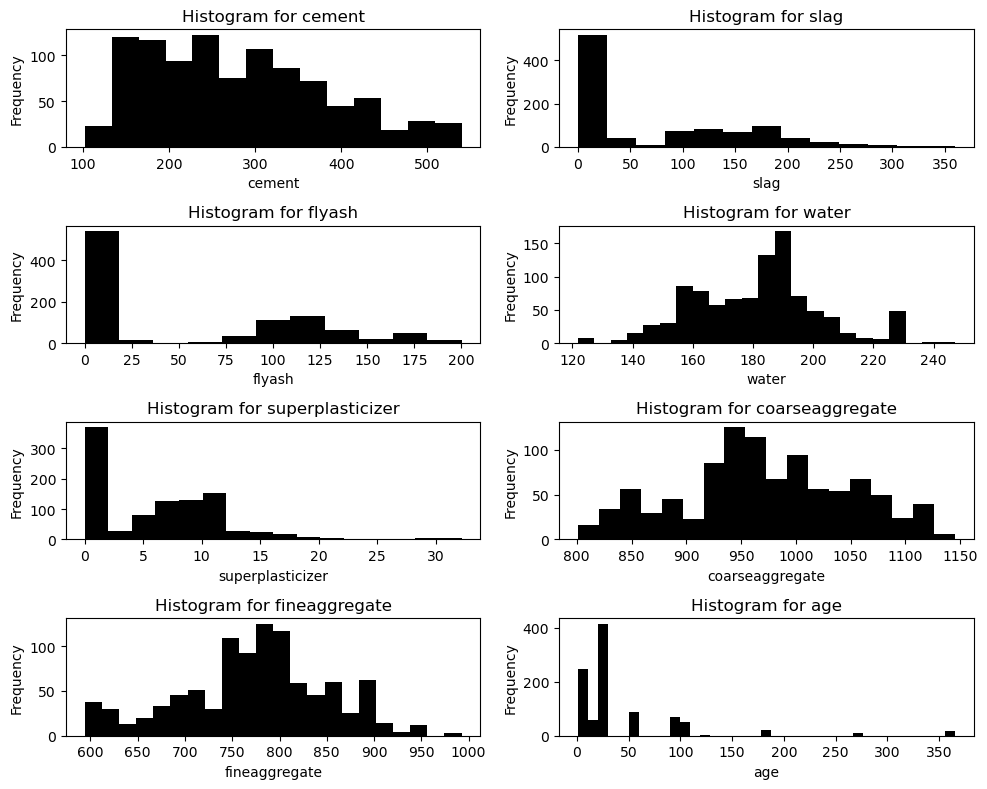

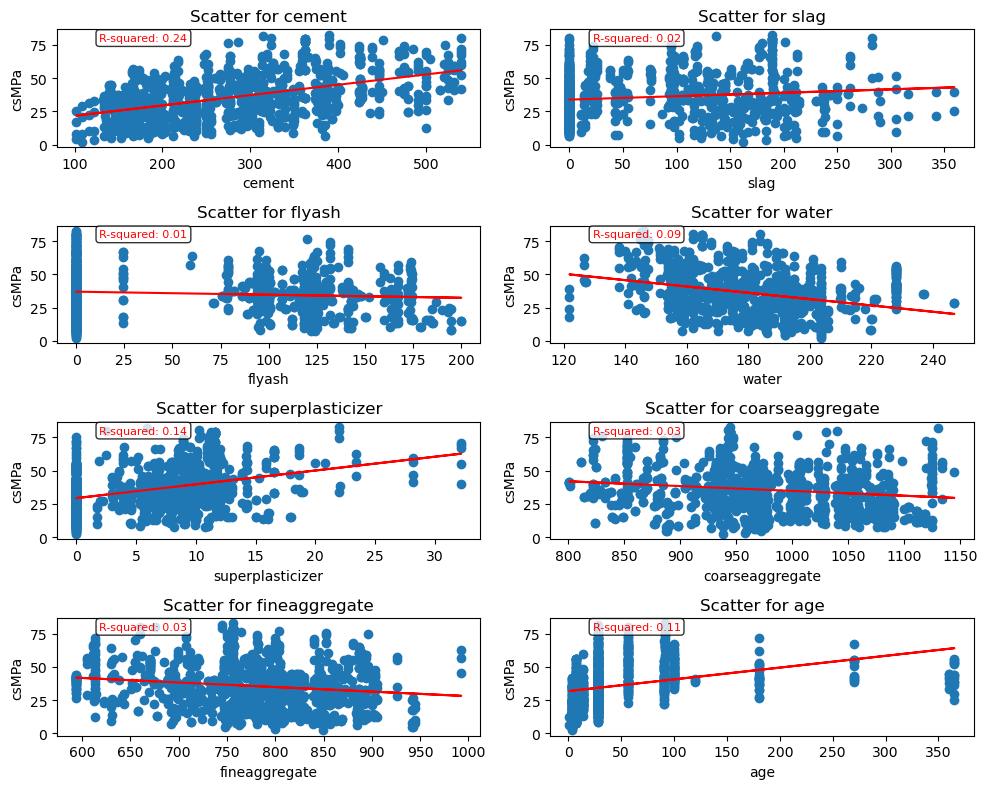

In [4]:
class DataVisualizer:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def plot_histograms(self):
        # Set the number of columns for the graphs' grid
        num_cols = 2

        # Calculate the number of rows needed based on the number of columns
        num_rows = math.ceil(len(self.x.columns) / num_cols)

        # Create subplots with a grid layout
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))

        # Flatten the axes for easy iteration
        axes = axes.flatten()

        # Iterate through each column
        for i, column in enumerate(self.x.columns):
            # Histogram
            axes[i].hist(self.x[column], bins='auto', color='black')
            axes[i].set_title(f'Histogram for {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Frequency')

        # Adjust layout for better visualization and show the plot
        plt.tight_layout()
        plt.show()

    def plot_scatter_plots(self):
        # Set the number of columns for scatter plots
        num_cols = 2

        # Calculate the number of rows needed based on the number of columns
        num_rows = math.ceil(len(self.x.columns) / num_cols)

        # Create subplots with a grid layout
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))

        # Flatten the axes for easy iteration
        axes = axes.flatten()

        # Iterate through each column for scatter plots
        for i, column in enumerate(self.x.columns):
            # Scatter plot
            axes[i].scatter(self.x[column], self.y)
            axes[i].set_title(f'Scatter for {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('y')

            # Fit a linear regression model
            slope, intercept = np.polyfit(self.x[column], self.y, 1)

            # Plot the regression line
            axes[i].plot(self.x[column], slope * self.x[column] + intercept, color='red')

            # Calculate R-squared
            y_pred = slope * self.x[column] + intercept
            r_squared = r2_score(self.y, y_pred)

            # Display R-squared in a box with white background
            text_box_props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            axes[i].text(0.1, 0.9, f'R-squared: {r_squared:.2f}', transform=axes[i].transAxes,
                         fontsize=8, color='red', bbox=text_box_props)

        # Adjust layout for better visualization
        plt.tight_layout()
        plt.show()

# Example usage:
data_visualizer = DataVisualizer(x, y)
data_visualizer.plot_histograms()
data_visualizer.plot_scatter_plots()


## Data Scaling and Scatter Plot for Machine Learning

The code begins by utilizing the `StandardScaler` from the scikit-learn library to standardize the features in the dataset (`x`). Standardization involves transforming the data so that it has a mean of 0 and a standard deviation of 1. This is essential in machine learning for models that rely on distance metrics, ensuring that all features contribute equally.

For each feature in the dataset, the code displays examples of column data before and after scaling. The `StandardScaler` is fitted and applied separately to each feature to ensure that they are scaled independently. The resulting scaled data is stored in the DataFrame `x_scaled`.

Since age doesn't appear to be a binomial distribution, it is scaled using a log scale instead.

Afterwards, the code resets the state of the scaler and scales the entire dataset (`x`) using the same scaler. While it's common to scale features individually, there are cases where scaling the entire dataset may be preferred, for instance, when using algorithms that are sensitive to feature distributions.

The scatter plots provide insight into how the scaled features influence the target variable, and in this case, it emphasizes that all features are now standardized with a mean of 0 and unit standard deviation. This visual confirmation is valuable for ensuring that the features contribute uniformly to the predictive model, promoting fair comparisons and preventing any individual feature from dominating the others.

Scaling is a crucial step in preparing data for machine learning models, ensuring that features are on a similar scale and preventing certain features from dominating others. The scatter plot aids in the exploratory data analysis phase, allowing for an intuitive understanding of the relationships between individual features and the target variable. This visual inspection is valuable for feature selection and determining the potential impact of features on the predictive model.


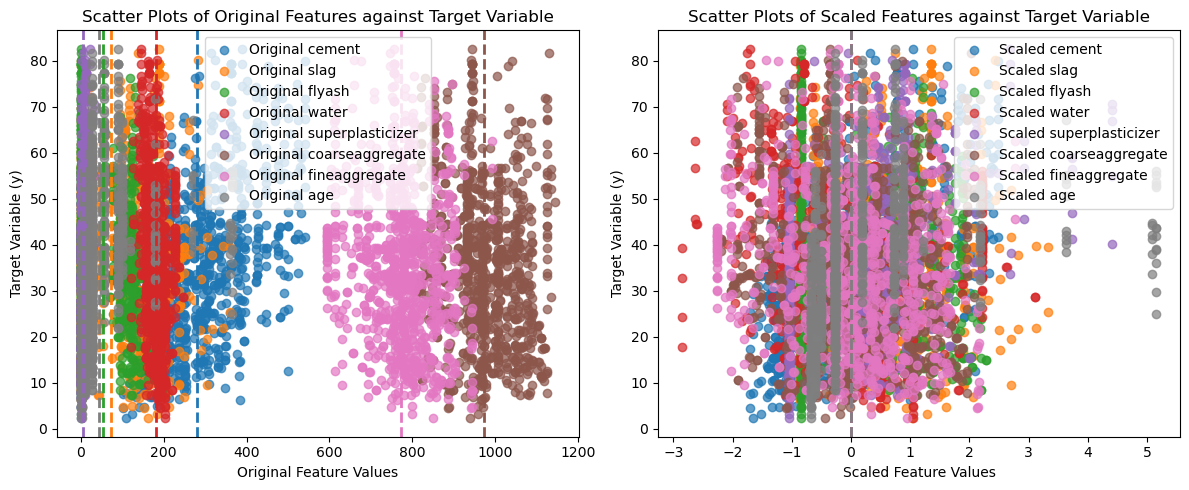

Before and After Scaling Information:
            Feature                 Before Scaling Example  \
0            cement    [540.0, 540.0, 332.5, 198.6, 380.0]   
1              slag         [0.0, 0.0, 142.5, 132.4, 95.0]   
2            flyash              [0.0, 0.0, 0.0, 0.0, 0.0]   
3             water    [162.0, 162.0, 228.0, 192.0, 228.0]   
4  superplasticizer              [2.5, 2.5, 0.0, 0.0, 0.0]   
5   coarseaggregate  [1040.0, 1055.0, 932.0, 978.4, 932.0]   
6     fineaggregate    [676.0, 676.0, 594.0, 825.5, 594.0]   
7               age      [28.0, 28.0, 270.0, 360.0, 365.0]   

                               After Scaling Example  
0  [2.4776627118993515, 2.4776627118993515, 0.493...  
1  [-0.8568321189023036, -0.8568321189023036, 0.8...  
2  [-0.8516316872189137, -0.8516316872189137, -0....  
3  [-0.9403854023795539, -0.9403854023795539, 2.2...  
4  [-0.622319191499265, -0.622319191499265, -1.04...  
5  [0.8656770445046826, 1.0581511258457748, -0.52...  
6  [-1.23368295187

In [34]:

class DataScaler:
    def __init__(self):
        """Initialize the DataScaler with a StandardScaler."""
        self.scaler = StandardScaler()

    def scale_column(self, column_data):
        """Scale a single column using the internal scaler."""
        return self.scaler.fit_transform(column_data).flatten()

    def scale_dataframe(self, df, columns):
        """Scale multiple columns in a DataFrame using the internal scaler."""
        df_scaled = df.copy()
        for column in columns:
            column_data = df[column].values.reshape(-1, 1)
            scaled_column = self.scale_column(column_data)
            df_scaled[column] = scaled_column.flatten()
        return df_scaled

def log_transform_age(dataframe):
    """Apply log transformation to the 'age' column."""
    df_copy = dataframe.copy()
    df_copy['age'] = np.log1p(df_copy['age'])
    return df_copy

def scatter_plot(data, target_variable, title, color):
    """
    Create a scatter plot for a given column against the target variable.
    Include a mean line with the same color as the data points.

    Parameters:
    - data: Column data to be plotted.
    - target_variable: Target variable data.
    - title: Title for the scatter plot.
    - color: Color for both the data points and mean line.
    """
    points = plt.scatter(data, target_variable, label=title, alpha=0.7, color=color)
    plt.axvline(data.mean(), color=color, linestyle='dashed', linewidth=2)

def visualize_data(x, y, x_scaled, x_columns):
    """Create side-by-side scatter plots for original and scaled features against the target variable."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Scatter Plots of Original Features against Target Variable")
    for i, column in enumerate(x_columns):
        scatter_plot(x[column], y, f"Original {column}", plt.cm.tab10(i))

    plt.xlabel("Original Feature Values")
    plt.ylabel("Target Variable (y)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Scatter Plots of Scaled Features against Target Variable")
    for i, column in enumerate(x_scaled.columns):
        scatter_plot(x_scaled[column], y, f"Scaled {column}", plt.cm.tab10(i))

    plt.xlabel("Scaled Feature Values")
    plt.ylabel("Target Variable (y)")
    plt.legend()

    plt.tight_layout()
    plt.show()

def display_scaling_info(scaling_info):
    """Display information about the before and after scaling values in a table."""
    print("Before and After Scaling Information:")
    print(scaling_info)

def main():
    """Main function to orchestrate the scaling and visualization process."""
    scaler = DataScaler()

    # Apply log transformation to the "age" column
    x_log_transformed = log_transform_age(x)
    column_data = x_log_transformed['age'].values.reshape(-1, 1)
    scaled_age = scaler.scale_column(column_data)

    # Display examples of column data before and after scaling
    scaling_info = []

    for column in x_columns:
        before_scaling_example = x[column].head().tolist()
        scaled_column = scaler.scale_column(x[column].values.reshape(-1, 1)).flatten()
        after_scaling_example = scaled_column[:5].tolist()

        scaling_info.append({
            'Feature': column,
            'Before Scaling Example': before_scaling_example,
            'After Scaling Example': after_scaling_example
        })

    # Convert the list to a DataFrame
    scaling_info_df = pd.DataFrame(scaling_info)

    # Scale the entire dataset using the same scaler
    x_scaled = scaler.scale_dataframe(x, x_columns)

    visualize_data(x, y, x_scaled, x_columns)
    display_scaling_info(scaling_info_df)

if __name__ == "__main__":
    main()


The next bit of code shows that scaling the data has had a marginal effect on the performance of the regressor as well as making it work marginally quicker.

In [6]:
# Create an instance of RandomForestRegressor for the original dataset
reg_original = RandomForestRegressor()

# Perform k-fold cross-validation for the original dataset
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores_original = []
fit_times_original = []

for train_index, test_index in kfold.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    start_time = time.time()
    reg_original.fit(x_train, y_train)
    end_time = time.time()

    fit_time_original = end_time - start_time
    fit_times_original.append(fit_time_original)

    score_original = reg_original.score(x_test, y_test)
    scores_original.append(score_original)

# Print the average R-squared score and fit time for the original dataset
print("Average R-squared score (Original Dataset):", np.mean(scores_original))
print("Average Fit time (Original Dataset):", np.mean(fit_times_original))

# Create an instance of RandomForestRegressor for the scaled dataset
reg_scaled = RandomForestRegressor(random_state=42)

# Perform k-fold cross-validation for the scaled dataset
scores_scaled = []
fit_times_scaled = []

for train_index, test_index in kfold.split(x_scaled):
    x_train_scaled, x_test_scaled = x_scaled.iloc[train_index], x_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    start_time = time.time()
    reg_scaled.fit(x_train_scaled, y_train)
    end_time = time.time()

    fit_time_scaled = end_time - start_time
    fit_times_scaled.append(fit_time_scaled)

    score_scaled = reg_scaled.score(x_test_scaled, y_test)
    scores_scaled.append(score_scaled)

# Print the average R-squared score and fit time for the scaled dataset
print("\nAverage R-squared score (Scaled Dataset):", np.mean(scores_scaled))
print("Average Fit time (Scaled Dataset):", np.mean(fit_times_scaled))


Average R-squared score (Original Dataset): 0.9023467677370485
Average Fit time (Original Dataset): 0.8601089477539062

Average R-squared score (Scaled Dataset): 0.9038016727522791
Average Fit time (Scaled Dataset): 0.8449459075927734


## Defining Models and Hyperparameters 

This code segment is dedicated to model selection and hyperparameter tuning through k-fold cross-validation. It defines a set of regression models, including Random Forest (RF), K-Nearest Neighbors (KN), Support Vector Regressor (SVR), Ridge, Lasso, and Linear Regression (LR). To optimize each model's performance, a grid search approach is employed to explore various hyperparameter values for each model. The selected hyperparameters are determined based on their impact on cross-validated performance metrics, namely the R-squared score (Score) and Root Mean Squared Error (RMSE).

In [22]:
# Define models
models = {
    'RF': RandomForestRegressor(),
    'KN': KNeighborsRegressor(),
    'SVR': SVR(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LR': LinearRegression()
}

# Mapping of models to hyperparameter names and values
model_hyperparams = {
    'RF': {'param_name': 'n_estimators', 'param_values': list(range(20, 141, 30))},
    'KN': {'param_name': 'n_neighbors', 'param_values': list(range(1, 10, 2))},
    'SVR': {'param_name': 'gamma', 'param_values': list(np.logspace(-2, 1, num=min(4, 100), endpoint=True, base=10.0))},
    'Ridge': {'param_name': 'alpha', 'param_values': list(np.logspace(-2, 1, num=min(4, 100), endpoint=True, base=10.0))},
    'Lasso': {'param_name': 'alpha', 'param_values': list(np.logspace(-2, 1, num=min(4, 100), endpoint=True, base=10.0))},
    'LR': {'param_name': 'NA', 'param_values': ['NA']}
}


## Hyperparameter Tuning and Model Evaluation


This code snippet implements k-fold cross-validation to evaluate multiple machine learning models with different hyperparameters. The objective is to assess the performance of each model on various subsets of the dataset, providing a robust measure of their effectiveness.

## Implementation Details

- **Number of Trials:** The code allows for multiple trials, each involving the evaluation of models with different hyperparameters.
- **Number of Splits (k-fold):** K-Fold cross-validation is employed with a specified number of splits.
- **Models and Hyperparameters:** A list of machine learning models along with their corresponding hyperparameter search spaces is provided. The code iterates through these models and hyperparameters, fitting and evaluating them using k-fold cross-validation.
- **Scoring:** For each model and hyperparameter combination, the code calculates the model's score and Root Mean Squared Error (RMSE) on the validation data for each fold. These results are then stored in the `all_results` list.


K-fold cross-validation is a crucial technique in machine learning to assess a model's performance while addressing issues like overfitting or underfitting. It provides a more reliable estimate of a model's generalization performance compared to a single train-test split. The results stored in `all_results` can be further analyzed to identify the best-performing models and their corresponding hyperparameters.


In [29]:
class CrossValidator:
    def __init__(self, models, model_hyperparams, x_scaled, y, n_splits=2, random_state=27):
        self.models = models
        self.model_hyperparams = model_hyperparams
        self.x_scaled = x_scaled
        self.y = y
        self.n_splits = n_splits
        self.random_state = random_state
        self.all_results = []

    def perform_cross_validation(self):
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        for model_name, model_instance in self.models.items():
            hyper_params_info = self.model_hyperparams[model_name]
            hyper_params = hyper_params_info['param_values']
            param_name = hyper_params_info['param_name']

            for param in hyper_params:
                model_instance = self.models[model_name]
                if param_name != 'NA':
                    model_instance.set_params(**{param_name: param})

                scores = self._cross_validate_single_model(model_instance, kf)
                self._store_results(model_name, param, scores)

    def _cross_validate_single_model(self, model, kf):
        scores = []

        for train_index, val_index in kf.split(self.x_scaled):
            x_train, x_val = self.x_scaled.iloc[train_index], self.x_scaled.iloc[val_index]
            y_train, y_val = self.y.iloc[train_index], self.y.iloc[val_index]

            model.fit(x_train, y_train)

            score = model.score(x_val, y_val)
            y_pred = model.predict(x_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            scores.append({'Model': model.__class__.__name__, 'Score': score, 'RMSE': rmse})

        return scores

    def _store_results(self, model_name, param, scores):
        self.all_results.extend([{'Model': model_name, 'Hyperparameter': param, 'Score': score['Score'], 'RMSE': score['RMSE']}
                                 for score in scores])

# Example usage:
cross_validator = CrossValidator(models, model_hyperparams, x_scaled, y, n_splits=2, random_state=27)
cross_validator.perform_cross_validation()
all_results = cross_validator.all_results


## Model Performance
Finally, the code generates bar charts visualizing the best R-squared scores and RMSE values for each model, aiding in the comparative assessment of model performance. This process is essential in selecting the most suitable regression model for the given dataset, ensuring that the chosen model performs optimally and avoids overfitting or underfitting. The visualizations provide a clear overview of each model's strengths, aiding in the decision-making process for model deployment in real-world applications.



All Results with Hyperparameters:
    Model Hyperparameter     Score       RMSE
0      RF             20  0.868308   6.047531
1      RF             20  0.889225   5.470625
2      RF             50  0.873333   5.931019
3      RF             50  0.884618   5.583226
4      RF             80  0.874014   5.915074
5      RF             80  0.888809   5.480902
6      RF            110  0.880889   5.751413
7      RF            110  0.884472   5.586763
8      RF            140  0.871166   5.981547
9      RF            140  0.890249   5.445290
10     KN              1  0.627250  10.174369
11     KN              1  0.609582  10.270252
12     KN              3  0.669593   9.579068
13     KN              3  0.695975   9.062975
14     KN              5  0.646240   9.911807
15     KN              5  0.706191   8.909411
16     KN              7  0.620956  10.259907
17     KN              7  0.675939   9.356856
18     KN              9  0.613167  10.364785
19     KN              9  0.655098   9.653041

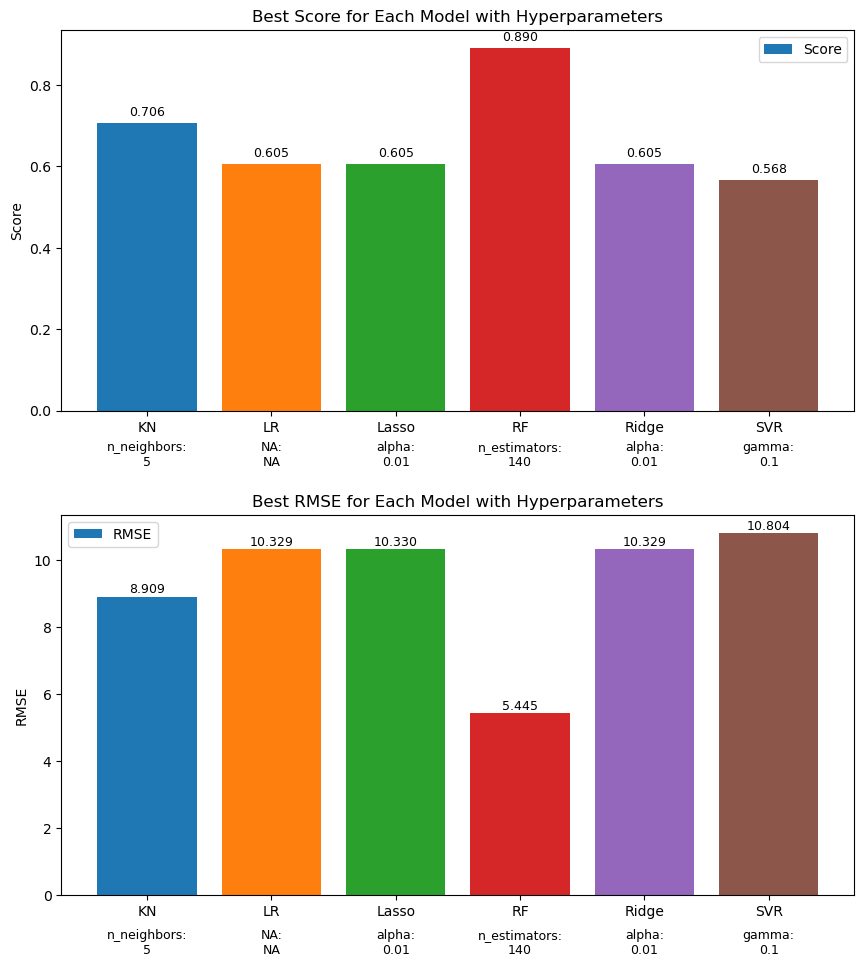

In [30]:
class ResultsVisualizer:
    def __init__(self, all_results, model_hyperparams):
        self.all_results = all_results
        self.model_hyperparams = model_hyperparams

    def plot_best_results(self):
        # Display all results with best hyperparameters, scores, and RMSE
        All_Results = pd.DataFrame(self.all_results)
        print("\nAll Results with Hyperparameters:")
        print(All_Results)

        # Find the index of the rows with the best scores for each model
        best_score_indices = All_Results.groupby('Model')['Score'].idxmax()
        best_rmse_indices = All_Results.groupby('Model')['RMSE'].idxmin()

        # Extract the corresponding rows
        best_scores_df = All_Results.loc[best_score_indices]
        best_rmse_df = All_Results.loc[best_rmse_indices]

        # Set a color palette (you can choose your own or use one of Matplotlib's built-in colormaps)
        colors = plt.cm.tab10.colors

        # Plot separate bar charts for the best scores and RMSE values, with different colors for each model
        fig, axes = plt.subplots(2, 1, figsize=(9, 10))

        # Plot for the best scores
        axes[0].bar(best_scores_df['Model'], best_scores_df['Score'], color=colors, label='Score')
        axes[0].set_ylabel('Score')
        axes[0].set_title('Best Score for Each Model with Hyperparameters')
        axes[0].legend()

        # Display hyperparameters, score, and RMSE values on top of each bar
        for idx, (value, model, hyperparameter) in enumerate(
            zip(best_scores_df['Score'], best_scores_df['Model'], best_scores_df['Hyperparameter'])
        ):
            param_name = self.model_hyperparams[model]['param_name']
            axes[0].text(idx, value + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=9, color='black')
            axes[0].text(
                idx, -0.075, f'{param_name}:\n{hyperparameter}', ha='center', va='top', fontsize=9, color='black'
            )

        # Plot for the best RMSE values
        axes[1].bar(best_rmse_df['Model'], best_rmse_df['RMSE'], color=colors, label='RMSE')
        axes[1].set_ylabel('RMSE')
        axes[1].set_title('Best RMSE for Each Model with Hyperparameters')
        axes[1].legend()

        # Display hyperparameters, score, and RMSE values on top of each bar
        for idx, (value, model, hyperparameter) in enumerate(
            zip(best_rmse_df['RMSE'], best_rmse_df['Model'], best_rmse_df['Hyperparameter'])
        ):
            param_name = self.model_hyperparams[model]['param_name']
            axes[1].text(idx, value + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=9, color='black')
            axes[1].text(
                idx, -1, f'{param_name}:\n{hyperparameter}', ha='center', va='top', fontsize=9, color='black'
            )

        # Adjust layout to prevent overlapping
        plt.tight_layout(pad=2.0)
        plt.show()

# Example usage:
results_visualizer = ResultsVisualizer(all_results, model_hyperparams)
results_visualizer.plot_best_results()


# Random Forest Hyperparameter Tuning with Cross-Validation
The primary goal of this code is to perform grid search for finding the best hyperparameters for a Random Forest Regressor model using cross-validation. By systematically exploring different combinations of hyperparameters, the code aims to identify the set of values that lead to the highest model performance.

## Hyperparameters and Search Space:
- **n_estimators:** Number of trees in the forest.
- **max_depth:** Maximum depth of the trees.
- **min_samples_split:** Minimum number of samples required to split an internal node.
- **min_samples_leaf:** Minimum number of samples required to be at a leaf node.

Cross-Validation Setup:
The code utilizes nested loops to iterate over various combinations of hyperparameters. For each combination, it performs k-fold cross-validation, training the Random Forest model on different subsets of the dataset and evaluating its performance on validation sets. The score represents the model's performance, and RMSE (Root Mean Squared Error) is calculated for additional evaluation.

When `n_jobs` is set to `-1`, it means that the algorithm should use all available processors or CPU cores to perform the computation in parallel.

Results, including hyperparameters and corresponding scores, are stored for further analysis. Additionally, a baseline Random Forest model is trained without hyperparameter tuning. The code prints a comparison between the best-performing model and the baseline model in terms of their scores.

In [27]:
class RandomForestRegressorOptimizer:
    def __init__(self, x_scaled, y, hyperparams):
        self.x_scaled = x_scaled
        self.y = y
        self.hyperparams = hyperparams

    def optimize(self, trials=1, n_splits=2):
        rf_results = []

        # Set Number of Trials and Number of Splits in KFold
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=27)

        # Separate Testing and Training Fractions (simple k-fold should work due to a large dataset/TimeSeriesSplit)
        for i in range(trials):
            # Reset scores list for each trial
            rf_scores = []

            # Iterate for Set List of Hyperparameters
            for n_estimators in self.hyperparams['n_estimators']:
                for max_depth in self.hyperparams['max_depth']:
                    for min_samples_split in self.hyperparams['min_samples_split']:
                        for min_samples_leaf in self.hyperparams['min_samples_leaf']:
                            # Instantiate the Random Forest model with the current hyperparameters
                            rf_model = RandomForestRegressor(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf,
                                n_jobs=-1
                            )

                            # Print current iteration information
                            print(f"\nIteration {i + 1} - Hyperparameters:")
                            print(f"Number of Estimators: {n_estimators}")
                            print(f"Max Depth: {max_depth}")
                            print(f"Min Samples Split: {min_samples_split}")
                            print(f"Min Samples Leaf: {min_samples_leaf}")

                            # Perform k-fold cross-validation
                            for train_index, val_index in kf.split(self.x_scaled):
                                x_train, x_val = self.x_scaled.iloc[train_index], self.x_scaled.iloc[val_index]
                                y_train, y_val = self.y.iloc[train_index], self.y.iloc[val_index]

                                # Fit the Random Forest model on the training data
                                rf_model.fit(x_train, y_train)

                                # Evaluate the model on the validation data and store the score and RMSE
                                score = rf_model.score(x_val, y_val)
                                y_pred_rf = rf_model.predict(x_val)
                                rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
                                rf_scores.append({
                                    'Model': 'RF',
                                    'Hyperparameter_n_estimators': n_estimators,
                                    'Hyperparameter_max_depth': max_depth,
                                    'Hyperparameter_min_samples_split': min_samples_split,
                                    'Hyperparameter_min_samples_leaf': min_samples_leaf,
                                    'Score': score,
                                    'RMSE': rmse_rf
                                })

                            # Clear the output for the next iteration
                            clear_output(wait=True)

            # Store the results for each Random Forest model in each trial
            rf_results.extend(rf_scores)

        return pd.DataFrame(rf_results)

# Define hyperparameters and their potential values
rf_hyperparams = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None] + list(range(5, 101, 10)),
    'min_samples_split': list(range(2, 21, 2)),
    'min_samples_leaf': list(range(1, 21, 2))
}

# Instantiate the optimizer
rf_optimizer = RandomForestRegressorOptimizer(x_scaled, y, rf_hyperparams)

# Perform optimization
rf_results_df = rf_optimizer.optimize()

# Extract the information about the best Random Forest regressor model
best_rf_index = rf_results_df['Score'].idxmax()
best_rf_info = rf_results_df.loc[best_rf_index]
best_rf_n_estimators = best_rf_info['Hyperparameter_n_estimators']
best_rf_max_depth = best_rf_info['Hyperparameter_max_depth']
best_rf_min_samples_split = best_rf_info['Hyperparameter_min_samples_split']
best_rf_min_samples_leaf = best_rf_info['Hyperparameter_min_samples_leaf']
best_rf_score = best_rf_info['Score']

# Print information about the best Random Forest regressor model
print("\nBest Random Forest Regressor:")
print(f"Number of Estimators: {best_rf_n_estimators}")
print(f"Max Depth: {best_rf_max_depth}")
print(f"Min Samples Split: {best_rf_min_samples_split}")
print(f"Min Samples Leaf: {best_rf_min_samples_leaf}")
print(f"Score: {best_rf_score:.3f}")

# Evaluate the Random Forest model without tuning other hyperparameters
baseline_rf_model = RandomForestRegressor(n_jobs=-1)
baseline_rf_model.fit(x_train, y_train)
baseline_rf_score = baseline_rf_model.score(x_val, y_val)

# Print comparison between the best Random Forest regressor and the baseline model
print("\nComparison with Baseline Random Forest Regressor:")
print(f"Score of Best Random Forest Regressor: {best_rf_score:.3f}")
print(f"Score of Baseline Random Forest Regressor: {baseline_rf_score:.3f}")



Best Random Forest Regressor:
Number of Estimators: 100
Max Depth: 55.0
Min Samples Split: 2
Min Samples Leaf: 1
Score: 0.891

Comparison with Baseline Random Forest Regressor:
Score of Best Random Forest Regressor: 0.891
Score of Baseline Random Forest Regressor: 0.888


This shows that optimising the hyperparameters of the Random Forest algorithm only marginally improves the score on this particular dataset.

# Model Predictivity

## Overfitting

The discrepancy between the R-squared scores on the training and test sets is a key observation. A significantly higher score on the training set compared to the test set suggests potential overfitting. Overfitting occurs when a model learns the training data too well, capturing noise and specific patterns that may not generalize well to new, unseen data. Although the model performs well on the training set, its effectiveness may diminish when applied to new data. To mitigate overfitting, one can explore strategies such as adjusting hyperparameters, increasing the size of the dataset, or implementing regularization techniques. 

It was found that the regressor overfit the data as the training set had a notably higher score than the test set, however, the score on the latter was still more than suitable.

In [9]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor instance
rf_model = RandomForestRegressor(random_state=42)

# Fit the Random Forest model on the training data
rf_model.fit(x_train, y_train)

# Predict the values on the training set
y_pred_train = rf_model.predict(x_train)

# Predict the values on the test set
y_pred_test = rf_model.predict(x_test)

# Calculate R-squared scores for training and test sets
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Print the R-squared scores
print(f"R-squared score on the training set: {r2_train:.3f}")
print(f"R-squared score on the test set: {r2_test:.3f}")


R-squared score on the training set: 0.984
R-squared score on the test set: 0.893


## Best Regressor
This code segment finalizes the evaluation and visualization steps for the best-performing regressor in the machine learning pipeline. Once the optimal regressor and its corresponding hyperparameters are determined based on cross-validation results, the script proceeds to fit this model to the entire dataset. Subsequently, the script generates predicted values for the dependent variable (y) using the trained regressor.

The visualization phase involves creating subplots for each feature against the compressive strength in the dataset, plotting the actual values (in blue) against the predicted values (in red) for the selected regressor. This visual inspection facilitates a qualitative assessment of how well the model captures the relationships between features and the target variable.

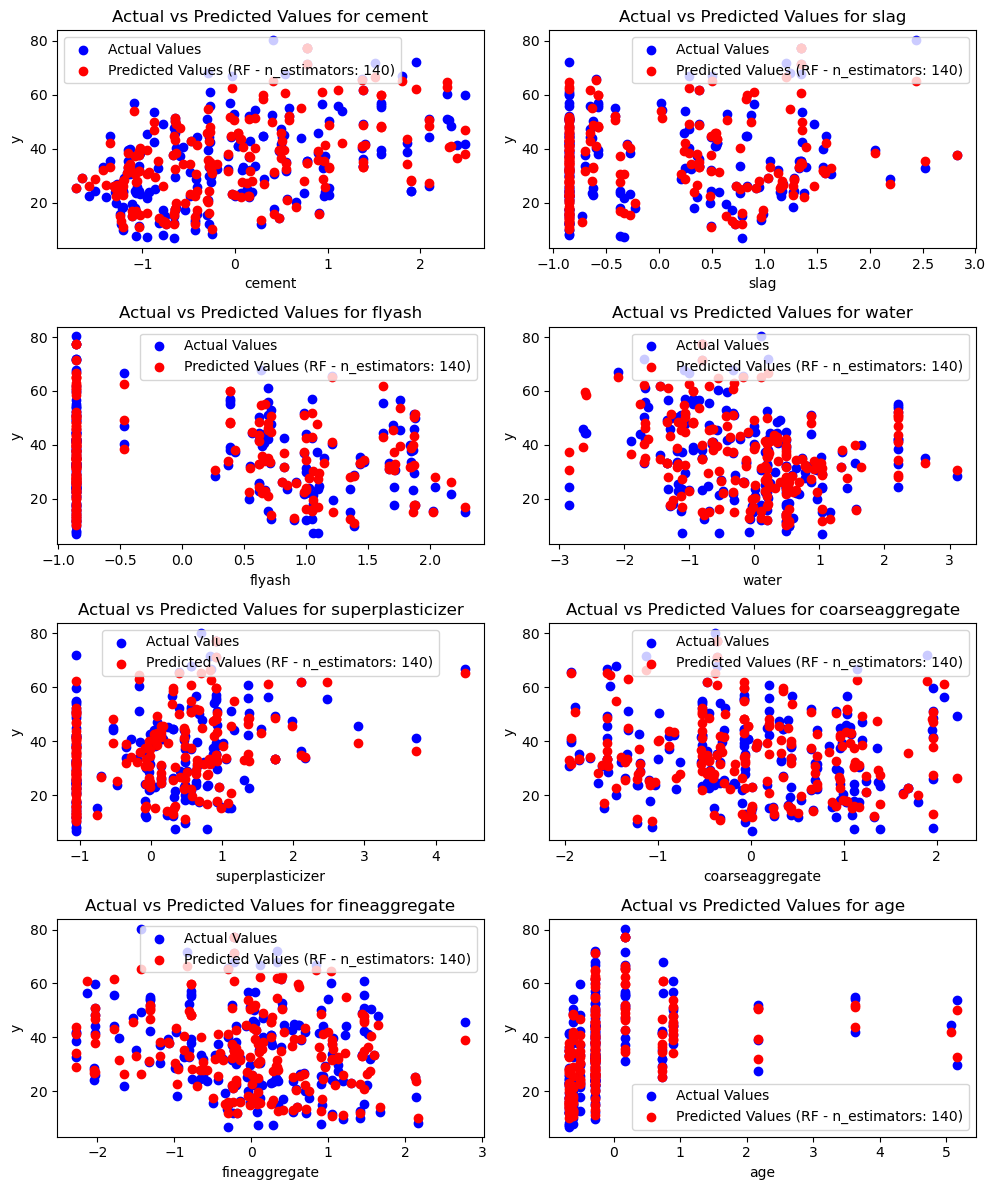

In [38]:

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# Extract information about the best regressor model
best_regressor_index = best_scores_df['Score'].idxmax()
best_regressor_info = All_Results.loc[best_regressor_index]
best_regressor = best_regressor_info['Model']
best_hyperparameter = best_regressor_info['Hyperparameter']
best_regressor_model = models[best_regressor]

# Set the best hyperparameter for the selected regressor
if best_hyperparameter != 'NA':
    param_name = model_hyperparams[best_regressor]['param_name']
    best_regressor_model.set_params(**{param_name: best_hyperparameter})

# Fit the best regressor model on the training data
best_regressor_model.fit(x_train, y_train)

# Predict the values on the test set
y_pred_test = best_regressor_model.predict(x_test)

# Get the number of features in the dataframe (excluding the last column)
num_features = len(data.columns) - 1

# Set the number of columns for subplots
num_cols = 2

# Calculate the number of rows and columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop through each feature in the dataframe (excluding the last column)
for i, feature_column in enumerate(data.columns[:-1]):
    # Plot the graph for each feature against the last column
    axes[i].scatter(x_test[feature_column], y_test, label='Actual Values', color='blue')
    axes[i].scatter(x_test[feature_column], y_pred_test,
                    label=f'Predicted Values ({best_regressor} - {param_name}: {best_hyperparameter})', color='red')
    axes[i].set_xlabel(feature_column)
    axes[i].set_ylabel('y')
    axes[i].legend()
    axes[i].set_title(f'Actual vs Predicted Values for {feature_column}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

>**Comparison of Actual and Predicted Values for each Feature using the Best Regressor Model**
This figure presents a visual examination of the relationship between actual and predicted values for each feature using the best regressor model. Each subplot corresponds to a different feature, with blue dots representing actual values and red dots representing predicted values obtained from the selected regressor model.


## Worst Regressor
This code block is dedicated to visualizing the performance of the worst-performing regressor among the best-performing models identified in the previous analysis. Similar to the visualization for the best regressor, this section plots scatter plots for each feature against the compressive strength, showcasing the actual values (in blue) and the predicted values (in red) generated by the worst-performing regressor among the best-performing models.

By examining the plots for the worst-performing regressor among the best models, we can analyze just how differently these predict the values, giving us valuable insight as to where these poorer perfoming models have failed more critically.

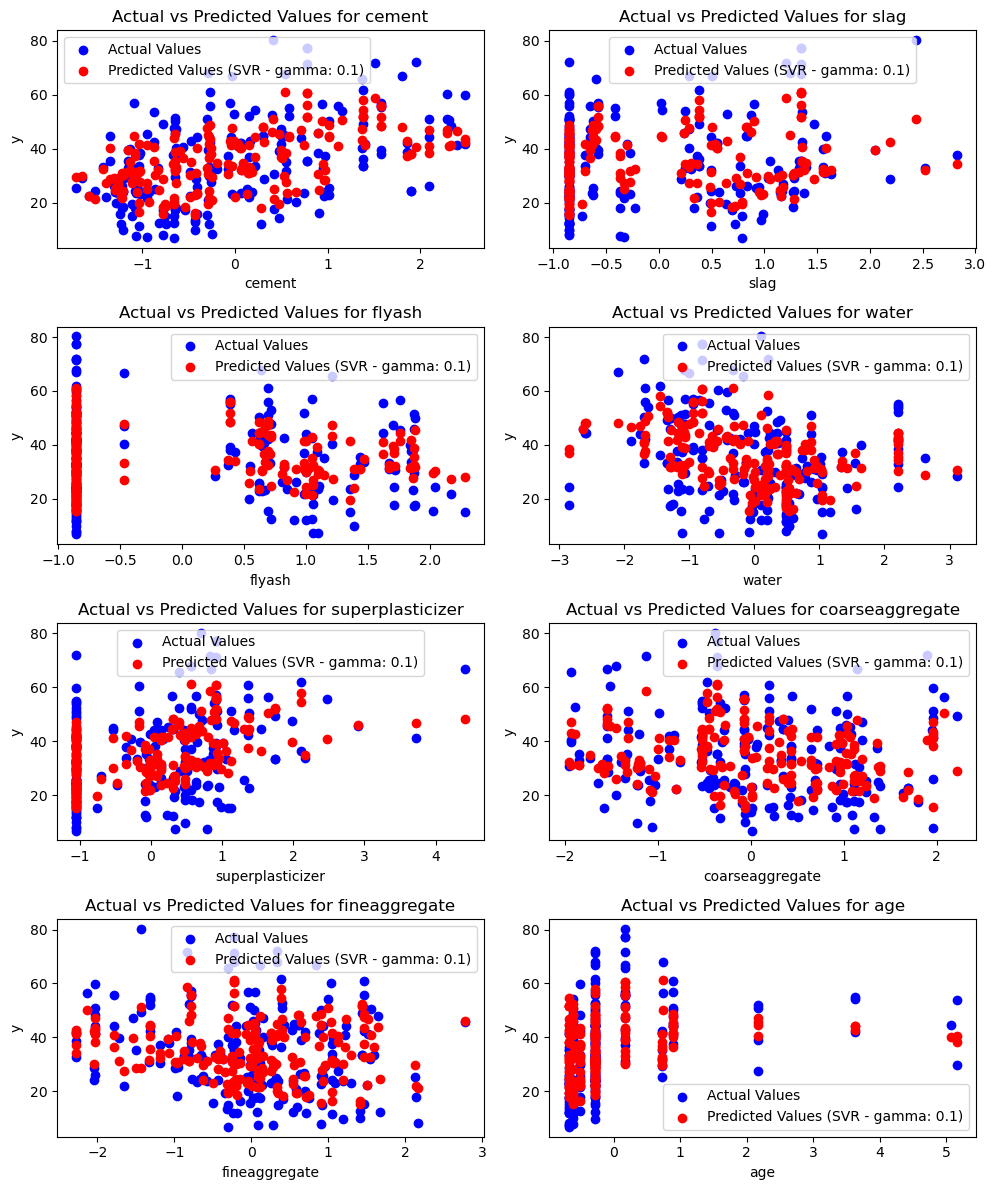

In [37]:
# Find the index of the rows with the worst scores for each model among the best performers
worst_score_indices_among_best = best_scores_df.groupby('Model')['Score'].idxmin()
worst_rmse_indices_among_best = best_rmse_df.groupby('Model')['RMSE'].idxmax()

# Extract the corresponding rows for the worst-performing regressor among the best performers
worst_scores_among_best = All_Results.loc[worst_score_indices_among_best]
worst_rmse_among_best = All_Results.loc[worst_rmse_indices_among_best]

# Extract the information about the worst-performing regressor among the best performers
worst_regressor_index_among_best = worst_scores_among_best['Score'].idxmin()
worst_regressor_info_among_best = All_Results.loc[worst_regressor_index_among_best]
worst_regressor = worst_regressor_info_among_best['Model']
worst_hyperparameter = worst_regressor_info_among_best['Hyperparameter']
worst_regressor_model_among_best = models[worst_regressor]

# Set the worst hyperparameter for the selected regressor
if worst_hyperparameter != 'NA':
    param_name = model_hyperparams[worst_regressor]['param_name']
    worst_regressor_model_among_best.set_params(**{param_name: worst_hyperparameter})

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# Fit the worst-performing regressor model among the best performers on the training data
worst_regressor_model_among_best.fit(x_train, y_train)

# Predict the values on the test set
y_pred_worst_regressor_among_best = worst_regressor_model_among_best.predict(x_test)

# Get the number of features in the dataframe (excluding the last column)
num_features = len(data.columns) - 1

# Set the number of columns for subplots
num_cols = 2

# Calculate the number of rows and columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop through each feature in the dataframe (excluding the last column)
for i, feature_column in enumerate(data.columns[:-1]):
    # Plot the graph for each feature against the last column using the test set
    axes[i].scatter(x_test[feature_column], y_test, label='Actual Values', color='blue')
    axes[i].scatter(x_test[feature_column], y_pred_worst_regressor_among_best,
                    label=f'Predicted Values ({worst_regressor} - {param_name}: {worst_hyperparameter})', color='red')
    axes[i].set_xlabel(feature_column)
    axes[i].set_ylabel('y')
    axes[i].legend()
    axes[i].set_title(f'Actual vs Predicted Values for {feature_column}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


>**Comparison of Actual and Predicted Values for each Feature using the Worst Regressor Model**
This figure presents a visual examination of the relationship between actual and predicted values for each feature using the worst regressor model. Each subplot corresponds to a different feature, with blue dots representing actual values and red dots representing predicted values obtained from the selected regressor model.

# Feature Importance


## Linear and Lasso Regression Coefficients

The Linear and Lasso Regression models are initially fitted using the training data, the gradient or magnitude of these coefficients are then calculated and visualized using a bar chart. Each feature is represented by a colored bar, with colors indicating the gradient of the corresponding coefficient. The primary objective of this visualization is to discern the impact of individual features on the prediction made by the Linear Regression model. 

In the bar chart, it's observed that the 'water' and 'superplasticizer' have the largest coefficients, which suggest they have the greatest impact on the predictivity. This insight is valuable for understanding the relative importance of features and potential areas for model improvement or refinement.

<IPython.core.display.Javascript object>


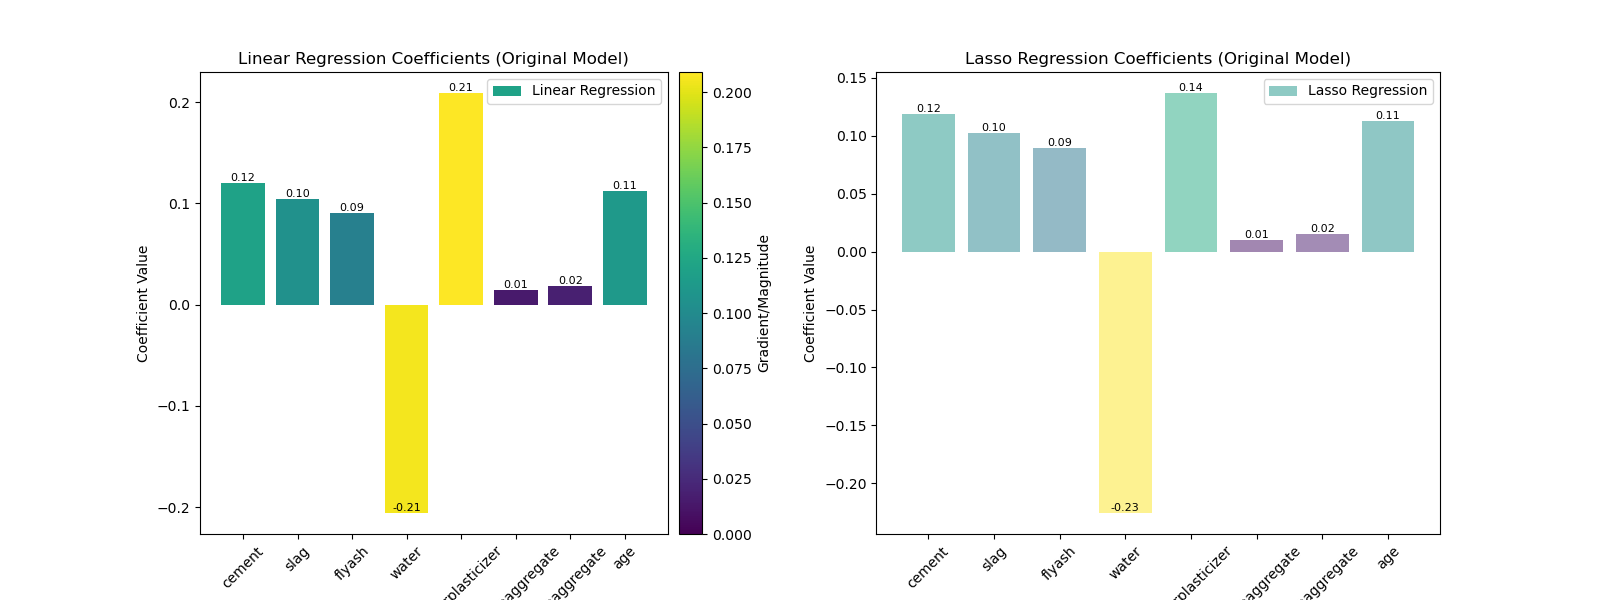

In [12]:
class CoefficientsVisualizer:
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def plot_coefficients(self, models):
        fig, axes = plt.subplots(1, len(models), figsize=(16, 6))

        for ax, model in zip(axes, models):
            # Fit the model on the training data
            model_instance = model['instance']
            model_instance.fit(self.x_train, self.y_train)

            # Get the coefficients and feature names
            coefficients = model_instance.coef_
            gradient = np.abs(coefficients)

            # Use the column names of x_train as feature names
            feature_names = self.x_train.columns

            # Plot the coefficients
            colors = plt.cm.viridis(gradient / np.max(gradient))
            bars = ax.bar(feature_names, coefficients, color=colors, alpha=0.7, label=model['name'])

            # Add a colorbar to show the gradient/magnitude information
            sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=np.max(gradient)))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
            cbar.set_label('Gradient/Magnitude')

            # Annotate each bar with the corresponding coefficient value
            for bar, coef_value in zip(bars, coefficients):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'{coef_value:.2f}', ha='center', va='bottom', fontsize=8,
                        color='black')

            ax.set_xlabel("Feature")
            ax.set_ylabel("Coefficient Value")
            ax.set_title(f"{model['name']} Coefficients")
            ax.tick_params(axis='x', rotation=45)
            ax.legend()

        plt.show()

# Example usage:
linear_regression_model = {'name': 'Linear Regression', 'instance': LinearRegression()}
lasso_regression_model = {'name': 'Lasso Regression', 'instance': Lasso(alpha=1.0)}  # You can adjust the alpha parameter as needed

coefficients_visualizer = CoefficientsVisualizer(x_train, y_train)
coefficients_visualizer.plot_coefficients([linear_regression_model, lasso_regression_model])


## Interactive Graph
The initial bar chart displays the scores of the Linear Regression and Random Forrest Regression models on the original dataset, serving as a baseline. As features are removed using the buttons, the chart dynamically updates to show the impact of removing each feature from the training set on the score.

The LR was added alongside the RF as random forest regression has some degree of randomness, which outweighs the effect of removing features which have little impact on the score. The ability to reset the dataset to its original state allows users to experiment with various feature combinations while maintaining a reference point.

<IPython.core.display.Javascript object>


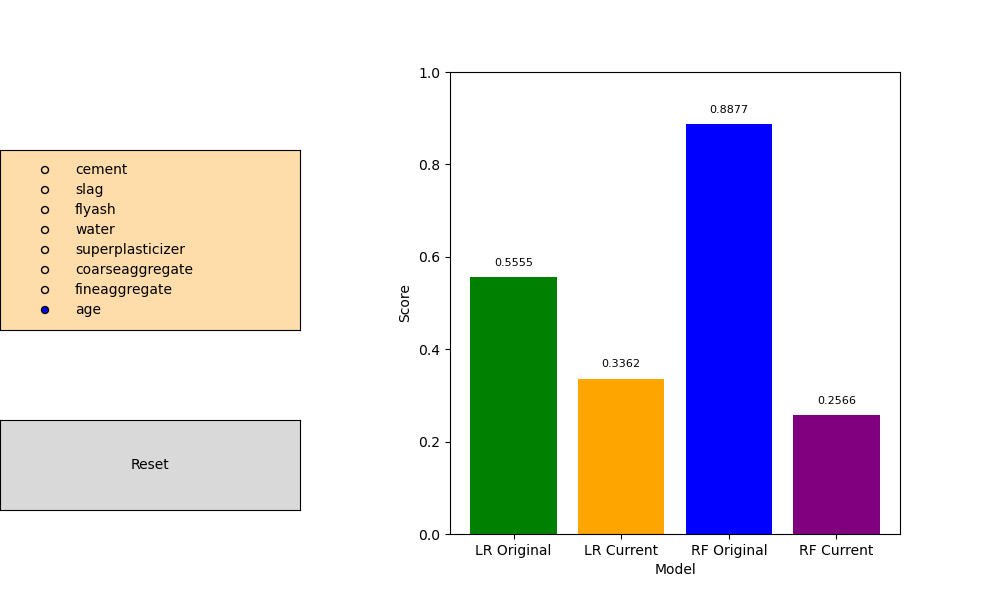

In [11]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons, Button
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Assume 'data' is your dataset
# If you haven't defined 'data' yet, you can replace it with your dataset in the code

# Define class for data preparation and model evaluation
class DataModelEvaluator:
    def __init__(self, original_data):
        self.original_data = original_data
        self.data = original_data.copy()
        self.features = list(self.data.columns[:-1])
        self.X, self.y = self.prepare_data(self.data)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.rf_original_score, self.lr_original_score = self.fit_and_evaluate_models(self.x_train, self.x_test, self.y_train, self.y_test)

    def prepare_data(self, data):
        X = data.drop(data.columns[-1], axis=1)
        y = data[data.columns[-1]]
        return X, y

    def fit_and_evaluate_models(self, x_train, x_test, y_train, y_test):
        rf_model = RandomForestRegressor(n_estimators=50).fit(x_train, y_train)
        rf_score = rf_model.score(x_test, y_test)
        lr_model = LinearRegression().fit(x_train, y_train)
        lr_score = lr_model.score(x_test, y_test)
        return rf_score, lr_score

    def fit_and_evaluate_current_models(self):
        x_train, x_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        rf_score, lr_score = self.fit_and_evaluate_models(x_train, x_test, y_train, y_test)
        return lr_score, rf_score

    def reset_data(self):
        self.data = self.original_data.copy()
        self.X, self.y = self.prepare_data(self.data)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.rf_original_score, self.lr_original_score = self.fit_and_evaluate_models(self.x_train, self.x_test, self.y_train, self.y_test)


# Define class for creating and updating the plot
class PlotUpdater:
    def __init__(self, evaluator, ax):
        self.evaluator = evaluator
        self.ax = ax
        self.colors = ["green", "orange", "blue", "purple"]
        self.index = ["LR Original", "LR Current", "RF Original", "RF Current"]

    def create_and_update_plot(self):
        self.ax.clear()
        scores = self.evaluator.fit_and_evaluate_current_models()
        bars = self.ax.bar(self.index, scores, color=self.colors)
        self.ax.set_xlabel("Model")
        self.ax.set_ylabel("Score")
        self.ax.set_ylim(0, 1)

        for bar, score in zip(bars, scores):
            self.ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.4f}', ha='center', va='bottom', fontsize=8, color='black')


# Initialize data evaluator and plot updater
data_evaluator = DataModelEvaluator(data)
plot_updater = PlotUpdater(data_evaluator, plt.subplots(figsize=(10, 6))[1])
plt.subplots_adjust(left=0.45)

# Create space for radio buttons and reset button on the side
radio_ax = plt.axes([0.0, 0.45, 0.3, 0.3], facecolor='#FFDDAA')
reset_ax = plt.axes([0.0, 0.15, 0.3, 0.15])

# Create radio buttons with vertical orientation
radio = RadioButtons(radio_ax, data_evaluator.features)

# Create reset button
reset_button = Button(reset_ax, "Reset")

# Define the callback function when the reset button is pressed.
def reset_callback(event):
    data_evaluator.reset_data()
    plot_updater.create_and_update_plot()

# Define the callback function when the feature removal button is pressed.
def feature_removal_callback(label):
    del data_evaluator.data[label]
    data_evaluator.X, data_evaluator.y = data_evaluator.prepare_data(data_evaluator.data)
    data_evaluator.x_train, data_evaluator.x_test, data_evaluator.y_train, data_evaluator.y_test = train_test_split(data_evaluator.X, data_evaluator.y, test_size=0.2, random_state=42)
    plot_updater.create_and_update_plot()

# Connect callbacks to buttons
radio.on_clicked(feature_removal_callback)
reset_button.on_clicked(reset_callback)

# Show bar chart
plt.show()


## Conclusion
Now ConcreteRules.ltd has an extremely accurate model for the compressive strength of concrete, and are aware that age seems to be the most impactful feature, while superplasticizer, has a small impact.